# Module import

In [69]:
import cuqi
import numpy as np
from cuqi.implicitprior import DenoiseRegularizer
from cuqi.experimental.mcmc import MYULANew
from cuqi.distribution import Posterior
import matplotlib.pyplot as plt

In [70]:
# Poisson solver
from utils import PoissonEfficient

In [71]:
import matplotlib 

fontsize = 20
legendfontsize = 18

matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 

# Forward operator, exact solution and noisy data

$$
\begin{aligned}
    \nabla\cdot(\kappa \nabla u) &= f&& \text{in $\Omega$}, \\
    u &= u_b&& \text{on $\partial\Omega$},
\end{aligned}
$$
where $\Omega$ is the domain of interest, $\partial\Omega$ is the boundary, $k$ is the conductivity, $u$ is the state, $f$ is the source function and $u_b$ are boundary value function.


- The mapping from $f$ to $u$ is linear
- Noisy measurement $y = u(f)+e$ and $e$ are i.i.d. Gaussian
- Our interest is to estimate $f$ based on $y$


([<matplotlib.axis.XTick at 0x7fffb5bdd490>,
 [Text(0.0, 0, '0'),
  Text(0.25, 0, '0.25'),
  Text(0.5, 0, '0.5'),
  Text(0.75, 0, '0.75'),
  Text(1.0, 0, '1')])

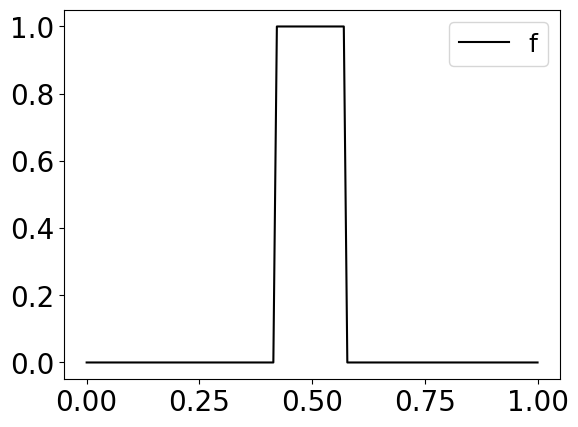

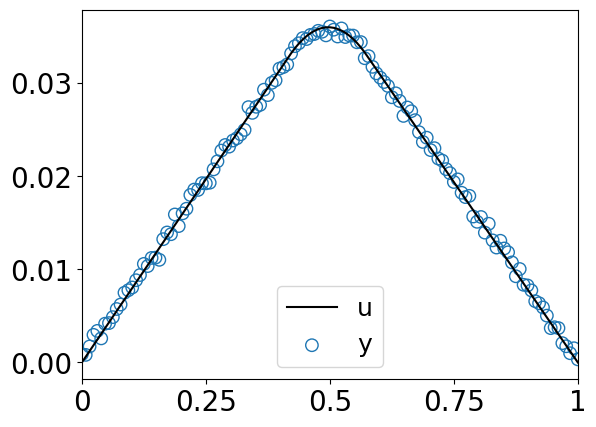

In [72]:
np.random.seed(0)

# %%
nx = 128
poisson = PoissonEfficient(nx)

signal_index = 0

if signal_index == 1:
    # truncated sine wave
    xx = np.linspace(0, 1, 128+1)
    x_exact = np.sin(4*np.pi*xx)
    x_exact[np.where(x_exact < 0)]=0
else:
    # square wave
    x_exact = np.zeros(nx+1)
    x_exact[int(nx/2)-10:int(nx/2)+10] = 1

    # x_exact[25:35] = 0.5

    # x_exact[45:60] = 1

    # x_exact[80:95] = 0.8

plt.figure()
plt.plot(np.linspace(0,1,nx+1), x_exact, label='f', color="k")
plt.legend(fontsize=legendfontsize, loc="upper right")

# %%
y_exact = poisson.forward(x_exact)

noise_scale = 5e-4#1e-3#5e-4
noise = noise_scale*np.random.randn(y_exact.size)
y_data = y_exact + noise
# %%
plt.figure()
plt.plot(np.linspace(0,1,nx+1), y_exact, label='u', color="k")
# plt.plot(np.linspace(0,1,nx+1), y_data, 'o', label='y', color="C2")
plt.scatter(np.linspace(0,1,nx+1), y_data, s=80, facecolors='none', edgecolors='C0', label="y")
plt.legend(fontsize=legendfontsize, loc="lower center")
# plt.ylim([0,0.05])
plt.xlim([0, 1])
plt.xticks([0, 0.25, 0.5, 0.75, 1], ['0', '0.25', '0.5', '0.75', '1'])

# Common variables

In [73]:
A = cuqi.model.LinearModel(poisson.forward, adjoint=poisson.adjoint, range_geometry=nx+1, domain_geometry=nx+1)

In [74]:
# Fixed (known) variance for the noise
measure_variance = np.ones(nx+1)*noise_scale**2
# measure_variance[0] = 1e4
# measure_variance[-1] = 1e4

In [75]:
num_samples = 500 #1000
num_burnin = 200

## Test scripts

- questions: hyperparamters?

In [76]:
y  = cuqi.distribution.Gaussian(A, measure_variance)

likelihood=y(y=y_data)


strength_reg=100
strength_smooth=0.5*noise_scale**2

from skimage.restoration import denoise_tv_chambolle
def prox_g(x, strength_reg=None, strength_smooth=None):
    weight=strength_reg*strength_smooth
    return denoise_tv_chambolle(x, weight=weight, max_num_iter=100), None
# %%
# We save all the important variables into the variable
# :math:`\texttt{denoiser_kwargs}`.
denoiser_kwargs={}
denoiser_kwargs["strength_reg"]=strength_reg
denoiser_kwargs["strength_smooth"]=strength_smooth
# %%
# Now we can define our implicit prior.
denoise_regularizer = DenoiseRegularizer(
    prox_g,
    strength_smooth=strength_smooth,
    denoiser_kwargs=denoiser_kwargs,
    geometry=likelihood.model.domain_geometry
)

# %%
# Implicitly defined posterior distribution
# -----------------------------------------
# We can now define the implicitly defined posterior distribution as follows:
posterior=Posterior(likelihood, denoise_regularizer)

  0% (0 of 30000) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (9 of 30000) |                      | Elapsed Time: 0:00:00 ETA:   0:06:58
  0% (24 of 30000) |                     | Elapsed Time: 0:00:00 ETA:   0:04:42
  0% (42 of 30000) |                     | Elapsed Time: 0:00:00 ETA:   0:03:53
  0% (59 of 30000) |                     | Elapsed Time: 0:00:00 ETA:   0:03:42
  0% (82 of 30000) |                     | Elapsed Time: 0:00:00 ETA:   0:03:19
  0% (112 of 30000) |                    | Elapsed Time: 0:00:00 ETA:   0:02:53
  0% (138 of 30000) |                    | Elapsed Time: 0:00:00 ETA:   0:02:46
  0% (163 of 30000) |                    | Elapsed Time: 0:00:00 ETA:   0:02:41
  0% (191 of 30000) |                    | Elapsed Time: 0:00:01 ETA:   0:02:37
  0% (211 of 30000) |                    | Elapsed Time: 0:00:01 ETA:   0:02:37
  0% (249 of 30000) |                    | Elapsed Time: 0:00:01 ETA:   0:02:27
  0% (295 of 30000) |                   

Selecting 5 randomly chosen variables


 None,

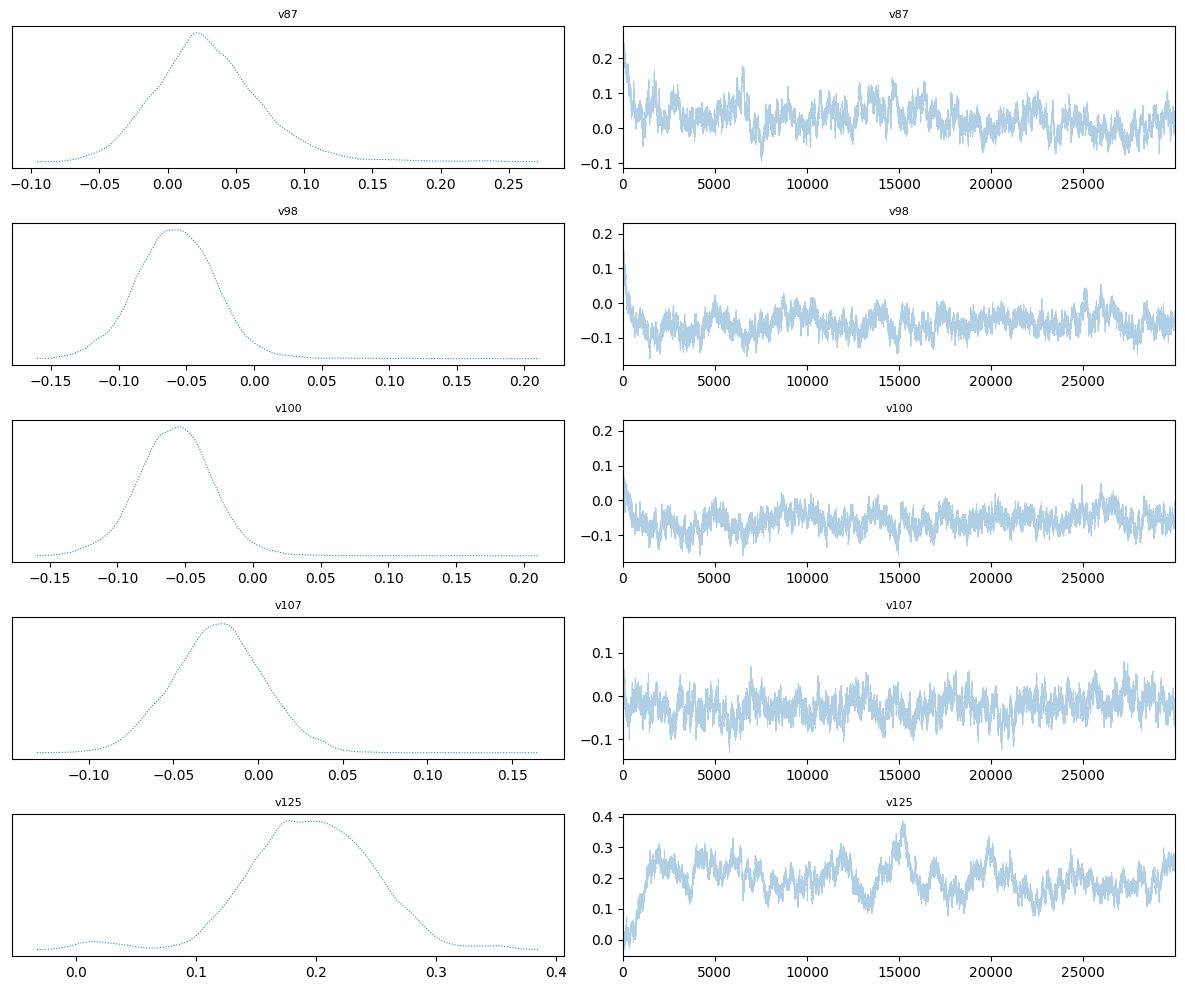

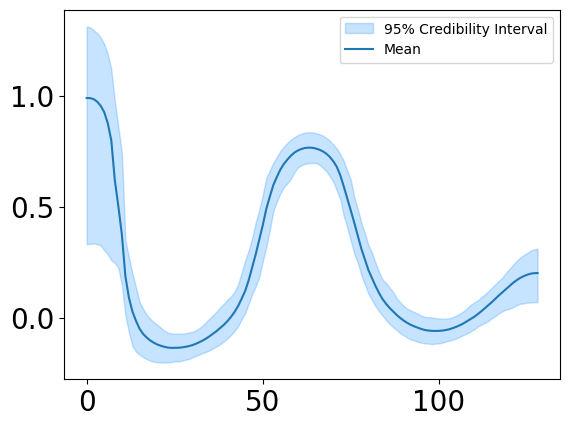

In [83]:
Ns=30000
Nb=20000
Nt=20
# Step-size of MYULA
# scale=0.9/(1/noise_scale**2 + 1/strength_smooth)
scale = 5e-5
# %%
# In order to get reproducible results, we set the seed parameter to 0.
np.random.seed(0)
# %%
# MYULA sampler
# -------------
# Definition of the MYULA sampler.
myula_sampler=MYULANew(target=posterior, scale=scale, initial_point=0.0*np.ones(nx+1))
# %%
# Sampling with MYULA.
myula_sampler.sample(Ns=Ns)
# %%
# Retrieve the samples. We apply the burnin and perform thinning to the Markov
# chain.
samples=myula_sampler.get_samples()
samples_warm=samples.burnthin(Nb=Nb, Nt=Nt)

samples.plot_trace()

plt.figure()
samples.plot_ci()


array([[<Axes: title={'center': 'v0'}>, <Axes: title={'center': 'v0'}>],
       [<Axes: title={'center': 'v60'}>, <Axes: title={'center': 'v60'}>],
       [<Axes: title={'center': 'v128'}>,
        <Axes: title={'center': 'v128'}>]], dtype=object)

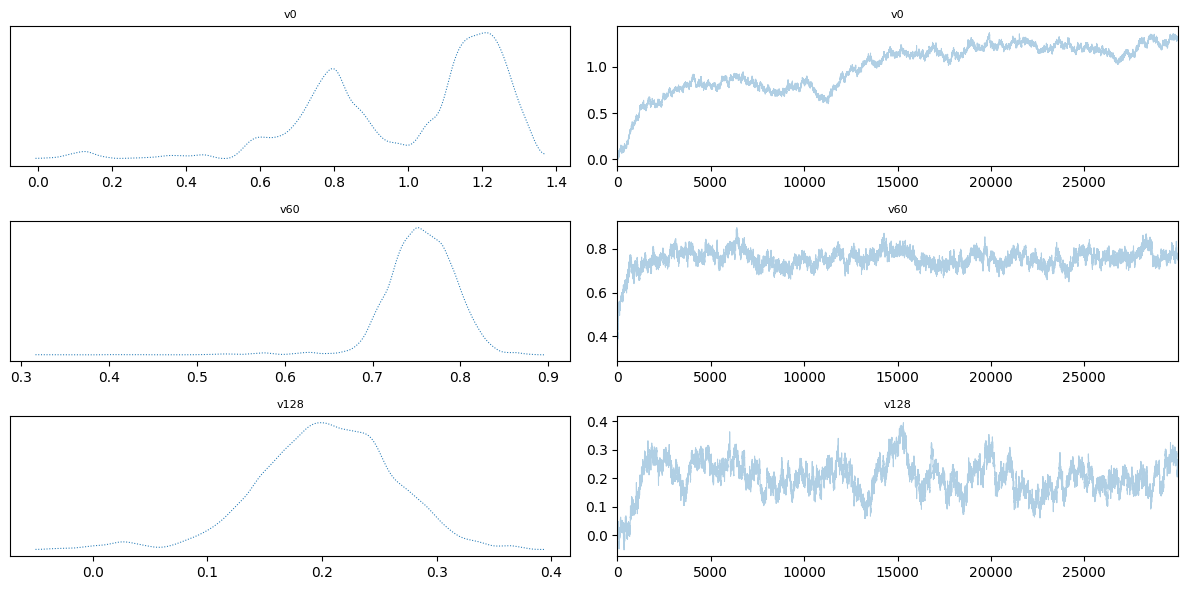

In [84]:
samples.plot_trace([0, 60, -1])

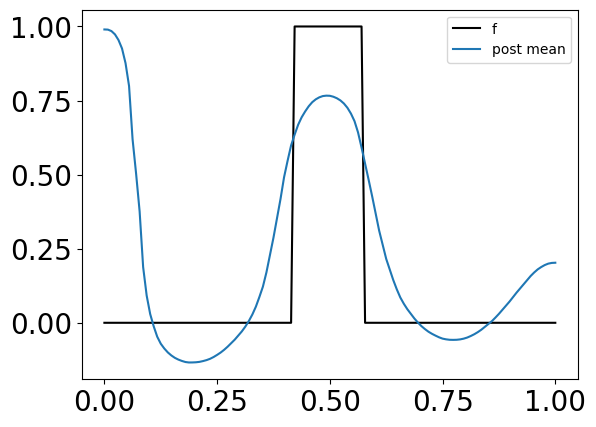

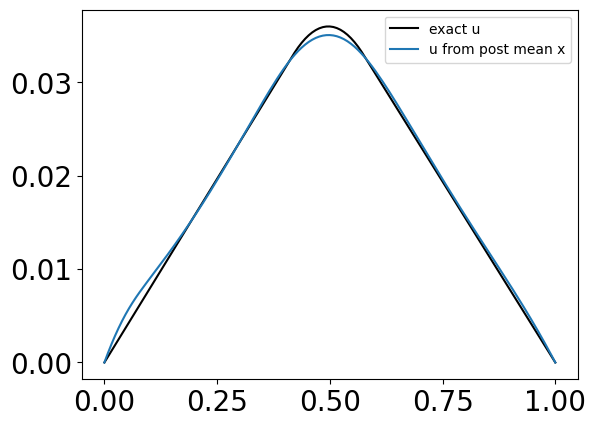

In [93]:
plt.figure()
plt.plot(np.linspace(0,1,nx+1), x_exact, label='f', color="k")
plt.plot(np.linspace(0,1,nx+1), samples.mean(), label='post mean', color="C0")
plt.legend()
plt.figure()
u_post = poisson.forward(samples.mean())
plt.plot(np.linspace(0,1,nx+1), y_exact, label='exact u', color="k")
plt.plot(np.linspace(0,1,nx+1), y_post, label='u from post mean x', color="C0")
plt.legend()
